In [1]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
import os

load_dotenv()
def set_env_vars(var):
    os.environ[var] = os.getenv(var)


vars = ["OPENAI_API_KEY", "LANGCHAIN_API_KEY", "LANGCHAIN_TRACING_V2", "LANGCHAIN_ENDPOINT", "LANGCHAIN_PROJECT", "TAVILY_API_KEY"]

for var in vars:
    set_env_vars(var)

llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
from typing import  List, Optional
from typing_extensions import TypedDict
from pydantic import BaseModel
from playwright.async_api import Page
from langchain_core.messages import BaseMessage
from langgraph.graph import MessagesState
from typing import Literal

from operator import add


class Bbox(TypedDict):
    id: int
    x: float
    y: float
    type: str
    text: str
    arialabel: str

class ImageScreenShoot(TypedDict):
    img : str
    bboxes : List[Bbox]

class Action(TypedDict):
    action: Literal["click_element", "scroll_element", "type_text", "wait", "go_back", "go_to_google", "ANSWER"]
    text_to_type: str
    bbox: Bbox

class AnswerNode(TypedDict):
    answer: str

class PlanState(TypedDict):
    plan: List[str]

class AgentState(MessagesState):
    task: str
    page: Page
    plan: PlanState
    screenshot: ImageScreenShoot
    tool_and_bbox_action: Action
    last_tool_action: str
    observation: str
    observation_history: List[str]
    answer: AnswerNode




In [4]:
import base64
import asyncio
from playwright.async_api import async_playwright
import asyncio
from PIL import Image as PILImage
import io


with open("mark_page.js") as f:
    mark_page_script = f.read()


async def mark_page(page):
    await page.evaluate(mark_page_script)
    for _ in range (10):
        try: 
            bboxes = await page.evaluate("markPage()")
            break
        except Exception:
            asyncio.sleep(3)
    # Get screenshot as bytes
    screenshot_bytes = await page.screenshot(path="screenshot.png")
    
    # Convert to PIL Image
    img = PILImage.open(io.BytesIO(screenshot_bytes))
    # Convert to grayscale to reduce color information
    img = img.convert('L')
    
    # Resize image (adjust dimensions as needed)
    max_size = (300, 300)  # You can adjust these dimensions
    img.thumbnail(max_size, PILImage.Resampling.LANCZOS)
    
    # Quantize the image to reduce number of colors
    img = img.quantize(colors=16)  # Reduce to 16 colors
    img = img.convert('L')  # Convert back to grayscale before JPEG saving

    # Save with compression
    buffer = io.BytesIO()
    img.save(buffer, format='JPEG', quality=5,  # Reduced quality
                optimize=True,  # Enable additional optimization
                progressive=True)  # Use progressive encoding
    compressed_bytes = buffer.getvalue()
    await page.evaluate("unmarkPage()")
    return ImageScreenShoot(img = base64.b64encode(compressed_bytes).decode("utf-8"), bboxes=bboxes)




async def browser_main(agent_state:AgentState):
    """
    This function is the main function that will be used to browse the web.
    It will take the agent state and return the agent state with the base64 encoded screenshot highlighting the actionable elements in bounding boxes.
    """
    print("********************BROWSER MAIN NODE********************\n")
    
    print("----------------------------------------------------------\n")
    print(f"Page: {agent_state["page"]}")
    print("----------------------------------------------------------\n")
    screenshot = await mark_page(agent_state["page"])

    print("----------------------------------------------------------\n")
    print(f"Screenshot: {screenshot}")
    print("----------------------------------------------------------\n")
    
    print("********************BROWSER MAIN NODE********************\n")
    return {"screenshot": screenshot}


In [5]:
from langchain_core.tools import Tool
from langchain_core.tools import StructuredTool
from langchain_core.messages import AIMessage, HumanMessage
import platform

async def click_element(agent_state: AgentState):
    """Click on a specified element on the webpage using its bounding box coordinates.
    
    Args:
        agent_state (AgentState): The current state of the agent containing page and action information
        
    
    """
    print("********************CLICK ELEMENT TOOL********************\n")
    print("----------------------------------------------------------\n")
    print(f"Agent State: {agent_state}")
    print("----------------------------------------------------------\n")
    page = agent_state["page"]
    print(f"Page: {page}")
    print("----------------------------------------------------------\n")
    tool_and_bbox_action = agent_state["tool_and_bbox_action"]
    print(f"Tool and Bbox Action: {tool_and_bbox_action}")
    print("----------------------------------------------------------\n")
    bbox = tool_and_bbox_action["bbox"]
    print(f"Bbox: {bbox}")
    print("----------------------------------------------------------\n")
    await page.mouse.click(bbox["x"], bbox["y"])
    sleep_time = 5
    await asyncio.sleep(sleep_time)
    bbox_text = bbox["text"]
    bbox_id = bbox["id"]
    return {"messages": [AIMessage(content=f"clicked element with id {bbox_id} and text {bbox_text}")], "last_tool_action": f"click_element with id {bbox_id} and text {bbox_text}"} # Return string, not dict

async def scroll_element(agent_state: AgentState):
    """Scroll the webpage up or down.
    
    Args:
        agent_state (AgentState): The current state of the agent containing page and action information
        
   
    """
    print("********************SCROLL TOOL********************\n")
    print("----------------------------------------------------------\n")
    print(f"Agent State: {agent_state}")
    print("----------------------------------------------------------\n")
    page = agent_state["page"]
    tool_and_bbox_action = agent_state["tool_and_bbox_action"]
    print(f"Tool and Bbox Action: {tool_and_bbox_action}")
    print("----------------------------------------------------------\n")
    bbox = tool_and_bbox_action["bbox"]
    print(f"Bbox: {bbox}")
    print("----------------------------------------------------------\n")
    await page.mouse.wheel(0, 200)
    bbox_text = bbox["text"]
    bbox_id = bbox["id"]
    sleep_time = 2
    await asyncio.sleep(sleep_time)
    return {"messages": [AIMessage(content=f"scrolled element with id {bbox_id} and text {bbox_text}")], "last_tool_action": f"scroll_element with id {bbox_id} and text {bbox_text}"} # Return string, not dict

async def type_text(agent_state: AgentState):
    """Type text into a specified element on the webpage.
    
    Args:
        agent_state (AgentState): The current state of the agent containing page and action information
        
    
    """
    print("********************TYPE TEXT TOOL********************\n")
    print("----------------------------------------------------------\n")
    print(f"Agent State: {agent_state}")
    print("----------------------------------------------------------\n")
    page = agent_state["page"]
    print(f"Page: {page}")
    print("----------------------------------------------------------\n")
    tool_and_bbox_action = agent_state["tool_and_bbox_action"]
    print(f"Tool and Bbox Action: {tool_and_bbox_action}")
    print("----------------------------------------------------------\n")
    bbox = tool_and_bbox_action["bbox"]
    print(f"Bbox: {bbox}")
    print("----------------------------------------------------------\n")
    bbox_text = bbox["text"]
    bbox_id = bbox["id"]
    await page.mouse.click(bbox["x"], bbox["y"])
    select_all = "Meta+A" if platform.system() == "Darwin" else "Control+A"
    await page.keyboard.press(select_all)
    await page.keyboard.press("Backspace")
    await page.keyboard.type(tool_and_bbox_action["text_to_type"])
    await page.keyboard.press("Enter")
    sleep_time = 3
    await asyncio.sleep(sleep_time)
    return {"messages": [AIMessage(content=f"typed text into element with id {bbox_id} and text {bbox_text}")], "last_tool_action": f"type_text with id {bbox_id} and text {bbox_text}"} # Return string, not dict


async def wait(agent_state: AgentState):
    print("********************WAIT NODE********************\n")
    print("----------------------------------------------------------\n")
    print(f"Agent State: {agent_state}")
    print("----------------------------------------------------------\n")
    sleep_time = 5
    await asyncio.sleep(sleep_time)
    return {"messages": [AIMessage(content=f"waited for {sleep_time} seconds")], "last_tool_action": f"wait for {sleep_time} seconds"} # Return string, not dict

async def go_back(agent_state: AgentState):
    print("********************GO BACK NODE********************\n")
    print("----------------------------------------------------------\n")
    print(f"Agent State: {agent_state}")
    print("----------------------------------------------------------\n")
    await agent_state["page"].go_back()
    return {"messages": [AIMessage(content=f"went back to the previous page")], "last_tool_action": f"go_back"} # Return string, not dict

async def go_to_google(agent_state: AgentState):
    print("********************GO TO GOOGLE NODE********************\n")
    print("----------------------------------------------------------\n")
    print(f"Agent State: {agent_state}")
    print("----------------------------------------------------------\n")
    await agent_state["page"].goto("https://www.google.com")
    return {"messages": [AIMessage(content=f"went to google")], "last_tool_action": f"go_to_google"} # Return string, not dict


In [6]:
from langchain_core.messages import SystemMessage, HumanMessage




def plan_node(agent_state: AgentState):
    print("********************PLAN NODE********************\n")
    print("----------------------------------------------------------\n")
    print(f"Agent State: {agent_state}")
    print("----------------------------------------------------------\n")
    screenshot = agent_state["screenshot"]
    print(f"Screenshot: {screenshot}")
    print("----------------------------------------------------------\n")
    system_prompt = """
    You are an AI assistant that can plan a sequence of actions to complete a task.
    You will be given a task and a screenshot of the webpage.
    You need to plan a sequence of actions on the webpage to complete the task or get close to completing the task.
    """

    human_prompt = """
    Here is the screenshot of the webpage:
    {screenshot}
    Here is the task:
    {task}
    """
    task = agent_state["task"]
    system_message = [SystemMessage(content=system_prompt)]
    human_message = [HumanMessage(content=human_prompt.format(screenshot=screenshot, task=task))]
    formatted_prompt = system_message + human_message

    structured_llm = llm.with_structured_output(PlanState)
    plan = structured_llm.invoke(formatted_prompt)

    print("----------------------------------------------------------\n")
    print(f"Plan: {plan}")
    print("----------------------------------------------------------\n")

    return {"plan": plan}


In [7]:
from langchain_core.messages import SystemMessage, HumanMessage



def answer_node(agent_state: AgentState):
    print("********************ANSWER NODE********************\n")
    print("----------------------------------------------------------\n")
    print(f"Agent State: {agent_state}")
    print("----------------------------------------------------------\n")
    screenshot = agent_state["screenshot"]
    print(f"Screenshot: {screenshot}")
    print("----------------------------------------------------------\n")
    
    system_prompt = """
    You are an AI assistant that can answer questions based on the screenshot of the webpage.
    You will be given a screenshot of the webpage and a question.
    You need to answer the question based on the screenshot.
    """
    
    human_prompt = """
    Here is the screenshot of the webpage:
    {screenshot}
    Here is the question:
    {question}
    """
    task = agent_state["task"]
    system_message = [SystemMessage(content=system_prompt)]
    human_message = [HumanMessage(content=human_prompt.format(screenshot=screenshot, question=task))]
    formatted_prompt = system_message + human_message
    
    structured_llm = llm.with_structured_output(AnswerNode)
    answer = structured_llm.invoke(formatted_prompt)
    print("----------------------------------------------------------\n")
    print(f"Answer: {answer['answer']}")
    print("----------------------------------------------------------\n")
    
    return {"answer": [answer['answer']]}


In [8]:

from langgraph.graph import StateGraph, START, END

def should_call_tool(agent_state: AgentState):
    tool_and_bbox_action = agent_state["tool_and_bbox_action"]
    action = tool_and_bbox_action["action"]
    if action == "click_element":
        return "click_element"
    elif action == "scroll_element":
        return "scroll_element"
    elif action == "type_text":
        return "type_text"
    elif action == "ANSWER":
        return "answer_node"
    elif action == "wait":
        return "wait"
    elif action == "go_back":
        return "go_back"
    elif action == "go_to_google":
        return "go_to_google"
    else:
        raise ValueError(f"Invalid action: {action}")
    

In [9]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from typing import Literal
from langgraph.graph import StateGraph, START, END


def get_action(agent_state: AgentState) -> Literal["click_element", "scroll_element", "type_text", "ANSWER", END]:
    print("********************GET ACTION NODE********************\n")

    print("----------------------------------------------------------\n")
    task = agent_state["task"]
    print(f"Task: {task}")
    print("----------------------------------------------------------\n")

    screenshot = agent_state["screenshot"]
    print(f"Screenshot: {screenshot}")
    print("----------------------------------------------------------\n")

    last_tool_action = agent_state["last_tool_action"]
    print(f"Last Tool Action: {last_tool_action}")
    print("----------------------------------------------------------\n")

    plan = agent_state["plan"]
    print(f"Plan: {plan}")
    print("----------------------------------------------------------\n")
    
    system_prompt = """
        You are an AI assistant that can browse the web and complete the user's task. You are given:

        1. The user's task (what they want to do or find).
        2. A screenshot of the current webpage (base64-encoded) plus a list of bounding boxes for elements on the page. Each bounding box has:
        • an id
        • x,y coordinates
        • a 'type' describing the element (e.g., 'button', 'input', 'div')
        • text describing the element's contents or label
        • aria-label describing any accessibility label
        3. The last action you took (if any), which can inform you about your next action.
        4. A plan of steps to follow, generated by the planning node.

        You should follow the provided plan while choosing your actions. The plan serves as a high-level guide for completing the task.

        You have **exactly six tools** you can call:
        1. click_element
        2. scroll_element
        3. type_text
        4. wait
        5. go_back
        6. go_to_google

        ### How to decide which tool to use:

        First, look at the current step in the plan. Then choose the appropriate tool that will help accomplish that step:

        - **go_to_google**: If the plan indicates starting a search and you're not on Google.
        - **click_element**: If the plan requires selecting or activating something on the page.
        - **type_text**: If the plan requires entering search terms or other text.
        - **scroll_element**: If you need to find elements mentioned in the plan that might be below the visible area.
        - **wait**: If you need to pause between steps in the plan for page loading.
        - **go_back**: If you need to return to a previous page to follow the plan correctly.

        ### Important:

        - Follow the plan sequence while choosing your tools. For example, if the plan says:
          1. "Go to Google"
          2. "Search for LA wildfires"
          3. "Look for recent news articles"
          
          You would execute this as:
          1. go_to_google
          2. click_element (search box) → type_text ("LA wildfires") → click_element (search button)
          3. scroll_element (to find news) → ANSWER (when relevant news is found)

        - Only return "ANSWER" when you've completed the plan and found the required information.
        - If you haven't completed all relevant steps in the plan, continue with the appropriate actions.

        Output JSON structure:
        {{
            "action": "click_element" | "scroll_element" | "type_text" | "wait" | "go_back" | "go_to_google" | "ANSWER"
            "bbox": {{
                "id": int,
                "x": float,
                "y": float,
                "type": str,
                "text": str,
                "aria-label": str
            }}
        }}

        Remember: Follow the plan while choosing your tools to ensure a systematic approach to completing the task.
    """
    
    system_message = [SystemMessage(content=system_prompt.format(screenshot=screenshot, last_tool_action=last_tool_action))]

    human_prompt = """Here is the task that needs to be completed: {task} \n
    Here is the screenshot of the webpage: {screenshot} \n
    Here is the last tool action you performed: {last_tool_action}
    Here is the plan: {plan}
    """

    human_message = [HumanMessage(content=human_prompt.format(task=task, screenshot=screenshot, last_tool_action=last_tool_action, plan=plan))]

    formatted_prompt = system_message + human_message

    print("----------------------------------------------------------\n")
    print(f"Formatted Prompt: {formatted_prompt}")
    print("----------------------------------------------------------\n")

    

    structured_llm = llm.with_structured_output(Action)
    response = structured_llm.invoke(formatted_prompt)


    print("----------------------------------------------------------\n")
    print(f"Tool and Bbox Action: {response}")
    print("----------------------------------------------------------\n")

    return {"tool_and_bbox_action": response}

#task = "Check out more tutorials"
#response = get_action(task)
#response

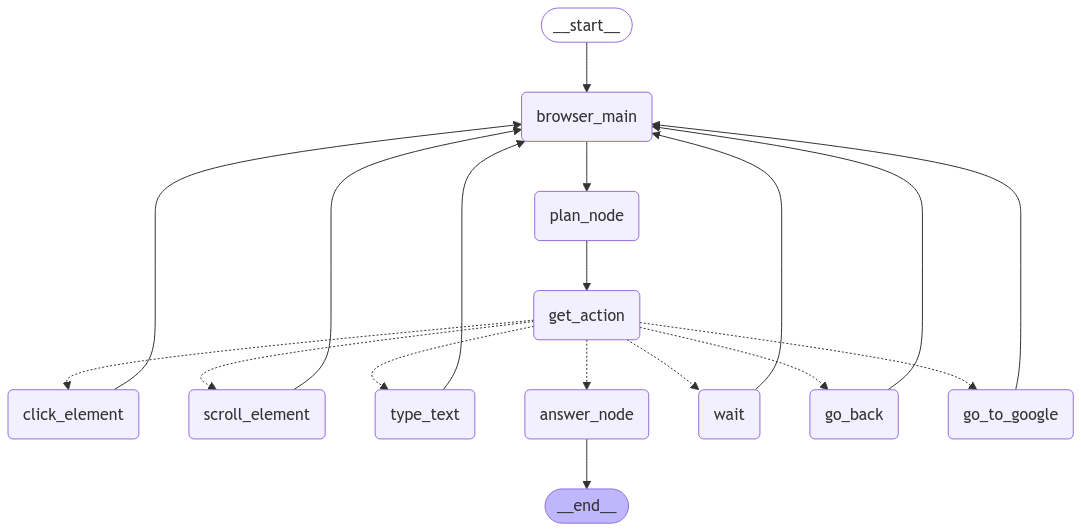

In [10]:
from IPython.display import display, Image
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(AgentState)

builder.add_node("browser_main", browser_main)
builder.add_node("plan_node", plan_node)
builder.add_node("get_action", get_action)
builder.add_node("click_element", click_element)
builder.add_node("scroll_element", scroll_element)
builder.add_node("type_text", type_text)
builder.add_node("answer_node", answer_node)
builder.add_node("wait", wait)
builder.add_node("go_back", go_back)
builder.add_node("go_to_google", go_to_google)


builder.add_edge(START, "browser_main")
builder.add_edge("browser_main", "plan_node")
builder.add_edge("plan_node", "get_action")
builder.add_conditional_edges("get_action", should_call_tool, [ "click_element", "scroll_element", "type_text", "wait", "go_back", "go_to_google", "answer_node"])
builder.add_edge("click_element", "browser_main")
builder.add_edge("scroll_element", "browser_main")
builder.add_edge("type_text", "browser_main")
builder.add_edge("wait", "browser_main")
builder.add_edge("go_back", "browser_main")
builder.add_edge("go_to_google", "browser_main")
builder.add_edge("answer_node", END)


graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))




In [11]:
async def setup_browser(go_to_page: str):
    playwright = await async_playwright().start()
    browser = await playwright.chromium.launch(headless=False)
    page = await browser.new_page()
    await page.goto(go_to_page)
    return playwright, browser, page



async def call_agent(task: str, go_to_page: str, max_steps: int = 250):
    playwright, browser, page = await setup_browser(go_to_page)
    final_answer = None
    event_stream = graph.astream(
        {
            "task": task, 
            "page": page, 
            "last_tool_action": "",
            "messages": [],
            "master_plan": None,
            "current_plan": None,
            "screenshot": None,
            "tool_and_bbox_action": None,
            "answer": None,
            "status": "in_progress"
        }, 
        {
            "recursion_limit": max_steps
        },
        stream_mode="values"
    )

    try:
        async for event in event_stream:
            print(event)
            if "answer" in event:
                final_answer = event["answer"]
                print("\nFinal Answer:", final_answer)
                break
            

    finally:
        await browser.close()
        await playwright.stop()
        return final_answer

task = "News on LA Wildfires"
go_to_page = "https://www.google.com"

final_answer = await call_agent(task, go_to_page)




{'messages': [], 'task': 'News on LA Wildfires', 'page': <Page url='https://www.google.com/'>, 'screenshot': None, 'tool_and_bbox_action': None, 'last_tool_action': '', 'answer': None}

Final Answer: None


In [11]:
print(final_answer[0])

TypeError: 'NoneType' object is not subscriptable